In [1]:
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, LSTM, GRU
from tensorflow.keras.initializers import Constant
from keras.layers import TextVectorization
import numpy as np
import pickle
import json

In [2]:
X = np.load('data/X.npy', allow_pickle=True)
y = np.load('data/y.npy')
embedding_matrix = np.load('data/embedding_matrix.npy')
num_tokens = np.load('data/num_tokens.npy').item()
embedding_dim = np.load('data/embedding_dim.npy').item()
max_tokens = np.load('data/max_tokens.npy').item()
max_len = np.load('data/max_len.npy').item()

In [3]:
vectorizer = TextVectorization(max_tokens=max_tokens,
                               standardize=None,
                               ngrams=(1, 2),
                               output_sequence_length=max_len)
vectorizer.adapt(X)

2022-02-02 19:47:26.320696: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-02 19:47:26.320800: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-02 19:47:26.350055: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-02 19:47:26.386053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M1 Pro


In [4]:
y = y.reshape((-1,1))

In [5]:
print(X.shape)
print(y.shape)

(8684,)
(8684, 1)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
np.save('data/x_train.npy', x_train)
np.save('data/y_train.npy', y_train)
np.save('data/x_test.npy', x_test)
np.save('data/y_test.npy', y_test)

In [8]:
sequences_input = Input(shape=(1), dtype='string')

vectorizer_sequence = vectorizer(sequences_input)

embedding_layer = Embedding(num_tokens,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            trainable=False)
embedded_sequences = embedding_layer(vectorizer_sequence)

x = Bidirectional(GRU(32, return_sequences=True))(embedded_sequences)
x = Dropout(0.2)(x)
x = Bidirectional(GRU(16, return_sequences=True))(x)
x = Dropout(0.2)(x)
x = Dense(10, activation="relu")(x)
x = Dropout(0.2)(x)

preds = Dense(units=1,
              kernel_initializer='uniform',
              activation='sigmoid')(x)
model = Model(sequences_input, preds)

model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 68)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 68, 100)           5000200   
                                                                 
 bidirectional (Bidirectiona  (None, 68, 64)           25728     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 68, 64)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 68, 32)           7872  

In [9]:
n_samples = x_train.shape[0]
model_n = 7

history = model.fit(x_train,
                    y_train,
                    validation_split=0.2,
                    batch_size=int(n_samples*0.1),
                    epochs=200)

model.save(f'models/model{model_n}.tf')

with open(f'models/history{model_n}.json', 'w') as f:
    json.dump(history.history, f)

Epoch 1/200


2022-02-02 19:47:30.534756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:47:30.973149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:47:30.986053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:47:31.190863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:47:31.202786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:47:31.482509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:47:31.509137: I tensorflow/core/grappler/optimizers/cust

9/9 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5098

2022-02-02 19:47:34.608386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:47:34.770785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:47:34.782163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:47:34.977947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:47:34.985138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 8s 450ms/step - loss: 0.6929 - accuracy: 0.5098 - val_loss: 0.6920 - val_accuracy: 0.5354
Epoch 2/200
9/9 [==============================] - 2s 185ms/step - loss: 0.6916 - accuracy: 0.5359 - val_loss: 0.6903 - val_accuracy: 0.5445
Epoch 3/200
9/9 [==============================] - 2s 181ms/step - loss: 0.6893 - accuracy: 0.5445 - val_loss: 0.6869 - val_accuracy: 0.5497
Epoch 4/200
9/9 [==============================] - 2s 193ms/step - loss: 0.6853 - accuracy: 0.5490 - val_loss: 0.6820 - val_accuracy: 0.5517
Epoch 5/200
9/9 [==============================] - 2s 191ms/step - loss: 0.6799 - accuracy: 0.5540 - val_loss: 0.6743 - val_accuracy: 0.5626
Epoch 6/200
9/9 [==============================] - 2s 189ms/step - loss: 0.6705 - accuracy: 0.5692 - val_loss: 0.6574 - val_accuracy: 0.5970
Epoch 7/200
9/9 [==============================] - 2s 182ms/step - loss: 0.6354 - accuracy: 0.6695 - val_loss: 0.5831 - val_accuracy: 0.7219
Epoch 8/200
9/9 [========

2022-02-02 19:53:08.749564: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-02-02 19:53:14.729800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: models/model7.tf/assets


INFO:tensorflow:Assets written to: models/model7.tf/assets


In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [11]:
y_pred = model.predict(x_test)

2022-02-02 19:53:28.941697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:53:29.087074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:53:29.095521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:53:29.284516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:53:29.290993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [12]:
y_pred = np.array([np.max(probs[:, 0]) for probs in y_pred])

In [13]:
def evaluate(y_true, y_pred, thresh):
    y_pred_ = (y_pred > thresh).astype(int)
    return accuracy_score(y_true, y_pred_), y_pred_

In [14]:
best_thresh = 0
best_accuracy = 0

for i in np.arange(0, 1, 0.01):
    print(f'Calculating thresh: {i}')
    score, _ = evaluate(y_test, y_pred, i)
    print(f'Accuracy: {score}')
    if score > best_accuracy:
        best_accuracy = score
        best_thresh = i

Calculating thresh: 0.0
Accuracy: 0.5020149683362118
Calculating thresh: 0.01
Accuracy: 0.5020149683362118
Calculating thresh: 0.02
Accuracy: 0.5020149683362118
Calculating thresh: 0.03
Accuracy: 0.5020149683362118
Calculating thresh: 0.04
Accuracy: 0.5020149683362118
Calculating thresh: 0.05
Accuracy: 0.5020149683362118
Calculating thresh: 0.06
Accuracy: 0.5020149683362118
Calculating thresh: 0.07
Accuracy: 0.5020149683362118
Calculating thresh: 0.08
Accuracy: 0.5020149683362118
Calculating thresh: 0.09
Accuracy: 0.5020149683362118
Calculating thresh: 0.1
Accuracy: 0.5020149683362118
Calculating thresh: 0.11
Accuracy: 0.5020149683362118
Calculating thresh: 0.12
Accuracy: 0.5020149683362118
Calculating thresh: 0.13
Accuracy: 0.5020149683362118
Calculating thresh: 0.14
Accuracy: 0.5020149683362118
Calculating thresh: 0.15
Accuracy: 0.5020149683362118
Calculating thresh: 0.16
Accuracy: 0.5020149683362118
Calculating thresh: 0.17
Accuracy: 0.5020149683362118
Calculating thresh: 0.18
Accur

In [15]:
score, y_pred = evaluate(y_test, y_pred, best_thresh)
print(score)

0.8031088082901554


In [16]:
y_pred_train = model.predict(x_train)
y_pred_train = np.array([np.max(probs[:, 0]) for probs in y_pred_train])
evaluate(y_train, y_pred_train, best_thresh)

(0.7873902403915359, array([0, 1, 0, ..., 0, 1, 0]))

In [17]:
confusion_matrix(y_test, y_pred)

array([[693, 172],
       [170, 702]])

In [18]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [19]:
history = history.history

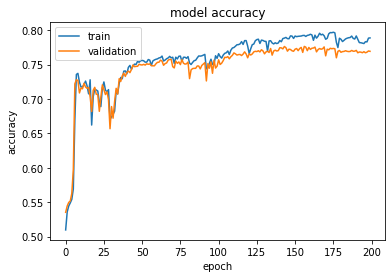

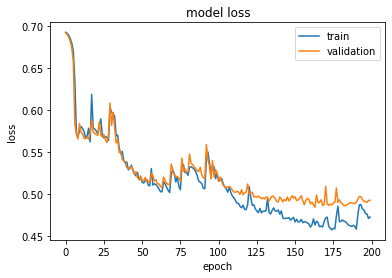

In [20]:
plt.subplots()
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

plt.subplots()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()